In [1]:
import pandas as pd

dataset=pd.read_csv('MoviesFinal.csv')

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import numpy as np
# dataframe functions
from pyspark.sql import functions as fn
from __future__ import division
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml import Pipeline
import pandas as pd
from pyspark.ml.feature import RegexTokenizer
# we obtain the stop words from a website
import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
stop_words[0:10]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

In [3]:
###############standard content reccomender
movie_df=spark.read.csv('MoviesFinal.csv',header=True,inferSchema=True)

In [4]:
movie_df

DataFrame[Release Year: string, Title: string, Origin/Ethnicity: string, Director: string, Cast: string, Genre: string, Wiki Page: string, Plot: string]

In [5]:
tokenizer = Tokenizer().setInputCol('Plot').setOutputCol('words')
movie_df=movie_df.filter(movie_df['Release Year']>1979)
movie_df=movie_df.na.drop()
# the tokenizer object
tokenizer = Tokenizer().setInputCol('Plot').setOutputCol('words')

movie_tokenizer=tokenizer.transform(movie_df)

from pyspark.ml.feature import CountVectorizer
from pyspark.ml import Pipeline

count_vectorizer_estimator = CountVectorizer().setInputCol('words').setOutputCol('features')

count_vectorizer_transformer=count_vectorizer_estimator.fit(movie_tokenizer)

count_vectorizer_transformer.transform(tokenizer.transform(movie_df)).show(truncate=False)

import pandas as pd

sentiments_df = spark.read.parquet('sentiments.parquet')

+------------+-----------------------------+----------------+---------------------------+-----------------------------------------------------------------------------------------------------+---------------+----------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
# we obtain the stop words from a website
import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
stop_words[0:10]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

In [7]:
from pyspark.ml.feature import StopWordsRemover
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

In [8]:
cv = CountVectorizer(minTF=1., minDF=5., vocabSize=2**17)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

In [9]:
cv_pipeline = Pipeline(stages=[tokenizer, sw_filter, cv]).fit(movie_df)
from pyspark.ml.feature import IDF
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')
idf_pipeline = Pipeline(stages=[cv_pipeline, idf]).fit(movie_df)

In [10]:
from pyspark.ml.feature import Word2Vec


# Learn a mapping from words to Vectors.
word2Vec = Word2Vec(vectorSize=3, minCount=0, inputCol="filtered", outputCol="result")
pipeline1=Pipeline(stages=[tokenizer, sw_filter, word2Vec])
model = pipeline1.fit(movie_df)

result = model.transform(movie_df)
#for row in result.collect():
    
     #Title, Origin, words,filtered,result= row
    #print("Text: [%s] => \nVector: %s\n" % (", ".join(text), str(vector)))

In [11]:
type(result.collect())

list

In [12]:
result.toPandas()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,words,filtered,result
0,2009,(500) Days of Summer,American,Marc Webb,"Joseph Gordon-Levitt, Zooey Deschanel",romantic comedy,https://en.wikipedia.org/wiki/(500)_Days_of_Su...,The film is presented in a nonlinear narrative...,"[the, film, is, presented, in, a, nonlinear, n...","[film, presented, nonlinear, narrative,, jumpi...","[0.019150215771514923, 0.12715337416157127, 0...."
1,2006,.45,American,Gary Lennon,"Milla Jovovich, Angus Macfadyen, Aisha Tyler, ...",crime drama,https://en.wikipedia.org/wiki/.45_(film),"Big Al (Angus Macfadyen), and his girlfriend K...","[big, al, (angus, macfadyen),, and, his, girlf...","[big, al, (angus, macfadyen),, girlfriend, kat...","[-0.05125619649735032, 0.15373151078440095, 0...."
2,2007,10 MPH,American,Hunter Weeks,Josh Caldwell's trip across the United States ...,documentary,https://en.wikipedia.org/wiki/10_MPH,10 MPH follows the progress of Caldwell as he ...,"[10 mph, follows, the, progress, of, caldwell,...","[10 mph, follows, progress, caldwell, rides, s...","[0.04401207631775017, 0.09451831466165082, 0.0..."
3,2008,"10,000 BC",American,Roland Emmerich,"Steven Strait, Camilla Belle, Cliff Curtis",adventure,"https://en.wikipedia.org/wiki/10,000_BC_(film)","""At about 10,000 BC, a tribe of hunter-gathere...","[""at, about, 10,000, bc,, a, tribe, of, hunter...","[""at, 10,000, bc,, tribe, hunter-gatherers, ca...","[0.082126465927757, 0.10371149088662696, 0.090..."
4,2000,102 Dalmatians,American,Kevin Lima,"Glenn Close, Gérard Depardieu, Alice Evans","comedy, family",https://en.wikipedia.org/wiki/102_Dalmatians,"After three years in prison, Cruella de Vil ha...","[after, three, years, in, prison,, cruella, de...","[years, prison,, cruella, vil, cured, desire, ...","[0.049946396161237215, 0.08269059535146493, 0...."
...,...,...,...,...,...,...,...,...,...,...,...
7844,1999,eXistenZ,American,David Cronenberg,"Jennifer Jason Leigh, Jude Law, Ian Holm",science fiction thriller,https://en.wikipedia.org/wiki/EXistenZ,"""In the near-future, biotechnological virtual ...","[""in, the, near-future,, biotechnological, vir...","[""in, near-future,, biotechnological, virtual,...","[0.06419091614791088, 0.05154800619412627, 0.0..."
7845,2017,iBoy,American,Adam Randall,"Adam Randall (director), Joe Barton (screenpla...","action, crime",https://en.wikipedia.org/wiki/IBoy,"Living in a gang ridden part of London, teenag...","[living, in, a, gang, ridden, part, of, london...","[living, gang, ridden, london,, teenage, boy, ...","[0.04020817984564928, 0.21159836975857615, 0.1..."
7846,2017,xXx: Return of Xander Cage,American,D. J. Caruso,"D. J. Caruso (director); F. Scott Frazier, Cha...","action, adventure",https://en.wikipedia.org/wiki/XXx:_Return_of_X...,"""NSA Agent Augustus Gibbons attempts to recrui...","[""nsa, agent, augustus, gibbons, attempts, to,...","[""nsa, agent, augustus, gibbons, attempts, rec...","[-0.08131350834321763, 0.09834341587764876, 0...."
7847,2005,Æon Flux,American,Karyn Kusama,Charlize Theron,science fiction,https://en.wikipedia.org/wiki/%C3%86on_Flux_(f...,"In 2011, a deadly pathogenic virus has killed ...","[in, 2011,, a, deadly, pathogenic, virus, has,...","[2011,, deadly, pathogenic, virus, killed, 99%...","[0.05555657245433675, 0.10600100514980464, 0.0..."


In [13]:
result2=result.drop('Release Year','Origin','Director','Cast','Genre','Wiki Page','Plot').show()

+--------------------+----------------+--------------------+--------------------+--------------------+
|               Title|Origin/Ethnicity|               words|            filtered|              result|
+--------------------+----------------+--------------------+--------------------+--------------------+
| (500) Days of Su...|        American|[the, film, is, p...|[film, presented,...|[0.01915021577151...|
|                 .45|        American|[big, al, (angus,...|[big, al, (angus,...|[-0.0512561964973...|
|              10 MPH|        American|[10 mph, follows,...|[10 mph, follows,...|[0.04401207631775...|
|           10,000 BC|        American|["at, about, 10,0...|["at, 10,000, bc,...|[0.08212646592775...|
|      102 Dalmatians|        American|[after, three, ye...|[years, prison,, ...|[0.04994639616123...|
|               11:14|        American|[the, film, invol...|[film, involves, ...|[0.06880811273463...|
|            12/12/12|        American|[the, film, begin...|[film, begins

In [14]:
len(result.collect()[0])

11

In [16]:
vectorslist=[]
movielist=[]
for row in result.collect():
    a,b,c,d,e,f,g,h,i,filtered,result= row
    print("Text: [%s] => \nVector: %s\n" % (", ".join(filtered), str(result)))
    vectorslist.append(result)
    movielist.append(b)

Text: [film, presented, nonlinear, narrative,, jumping, various, days, 500, days, tom, summer's, relationship., on-screen, timer, showing, day., following, linear, summary, plot.] => 
Vector: [0.019150215771514923,0.12715337416157127,0.10569800176890568]

Text: [big, al, (angus, macfadyen),, girlfriend, kat, (milla, jovovich),, small-time, crooks, dealing, guns, stolen, goods, queens,, new, york, city., fun, relationship, sex, booze., living, shabby, apartment,, traffic, illegal, handguns,, cleverly, avoiding, nypd, atf., however,, vic, (sarah, strange),, kat's, best, friend, (and, ex-lover), crush, her,, hates, big, al, doesn't, approve, relationship.] => 
Vector: [-0.05125619649735032,0.15373151078440095,0.16937798108164295]

Text: [10 mph, follows, progress, caldwell, rides, segway, scooter, united, states, seattle, boston,, stopping, places, way, interact, people., film, focuses, showing, dynamic, nature, countryside, documenting, stories, people, caldwell, weeks, encounter, way.] 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Text: [tess, mcgill, american, working-class, stockbroker's, secretary, staten, island, bachelor's, degree, business, evening, classes., works, mergers, acquisitions, department, wall, street, investment, bank., tess, aspires, reach, executive, position., tricked, boss, date, lascivious, cocaine, snorting, colleague,, gets, trouble, publicly, insulting, reassigned, secretary, new, financial, executive,, katharine, parker., seemingly, supportive,, katharine, encourages, tess, share, ideas., tess, suggests, client,, trask, industries,, invest, radio, gain, foothold, media., katharine, listens, idea, says, she'll, pass, people., later,, says, idea, wasn't, received., katharine, breaks, leg, skiing, europe,, asks, tess, house-sit., katharine's, place,, tess, discovers, meeting, notes, katharine, plans, pass, merger, idea, own., home,, tess, finds, boyfriend, mick, dugan, bed, woman., disillusioned,, returns, katharine's, apartment, begins, transformation.] => 
Vector: [0.00739978243396661

In [ ]:
vectorslist[1][1]

In [17]:
xdata=[]
ydata=[]
zdata=[]
arryN=numpy.empty
for i in range(len(vectorslist)):
    xdata.append(vectorslist[i][0])
    ydata.append(vectorslist[i][1])
    zdata.append(vectorslist[i][2])


In [18]:
len(movielist[:100])

100

In [19]:

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
len(xdata)

In [ ]:
movie

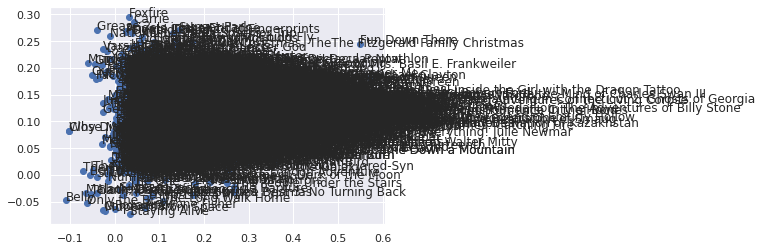

In [105]:
y = ydata
z = zdata
n = movielist[10:15]

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

In [ ]:
ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
zdata=zdata[:100]
xdata = xdata[:100]
ydata = ydata[:100]
mdata=movielist[:100]
ax.scatter3D(xdata, ydata, zdata, cmap='Greens');
for n, x, y, z in zip(mdata,xdata,ydata,zdata):
    label = '(%d, %d, %d), dir=%s' % (x, y, z, n)
    ax.text(x, y, z, label, n)


In [ ]:
ax = plt.axes(projection='3d')
ax = plt.figure().add_subplot(projection='3d')

# Demo 1: zdir
zdirs = tuple(movielist[:50])
xs = tuple(xdata[:50])
ys = tuple(ydata[:50])
zs = tuple(zdata[:50])

for zdir, x, y, z in zip(zdirs, xs, ys, zs):
    label = '(%d, %d, %d), dir=%s' % (x, y, z, zdir)
    ax.text(x, y, z, label, zdir)

# Demo 2: color
ax.text(9, 0, 0, "red", color='red')

# Demo 3: text2D
# Placement 0, 0 would be the bottom left, 1, 1 would be the top right.
ax.text2D(0.05, 0.95, "2D Text", transform=ax.transAxes)

# Tweaking display region and labels
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_zlim(0, 10)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()

In [ ]:
xdata.ndim

In [ ]:
type(tuple(xdata))

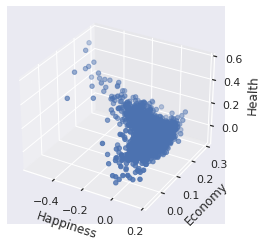

In [103]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = moviesetDf['x']
y = moviesetDf['y']
z = moviesetDf['z']
labels=moviesetDf['movie']
ax.set_xlabel("Happiness")
ax.set_ylabel("Economy")
ax.set_zlabel("Health")

ax.scatter(x, y, z)

plt.show()

In [ ]:
len(movielist)

In [44]:
moviesetDf=pd.DataFrame({'x':xdata, 'y':ydata,'z':zdata,'movie':movielist})
moviesetSpark=spark.createDataFrame(moviesetDf)

,x,y,z,movie
0,0.019150,0.127153,0.105698,(500) Days of Summer
1,-0.051256,0.153732,0.169378,.45
2,0.044012,0.094518,0.065745,10 MPH
3,0.082126,0.103711,0.090927,"10,000 BC"
4,0.049946,0.082691,0.082108,102 Dalmatians
...,...,...,...,...
7844,0.064191,0.051548,0.091090,eXistenZ
7845,0.040208,0.211598,0.109966,iBoy
7846,-0.081314,0.098343,0.209442,xXx: Return of Xander Cage
7847,0.055557,0.106001,0.017329,Æon Flux


In [49]:
moviesetSpark=spark.createDataFrame(moviesetDf)



In [50]:
moviesetSpark.show()

+--------------------+--------------------+--------------------+--------------------+
|                   x|                   y|                   z|               movie|
+--------------------+--------------------+--------------------+--------------------+
|0.019150215771514923| 0.12715337416157127| 0.10569800176890568| (500) Days of Su...|
|-0.05125619649735032| 0.15373151078440095| 0.16937798108164295|                 .45|
| 0.04401207631775017| 0.09451831466165082| 0.06574459731125208|              10 MPH|
|   0.082126465927757| 0.10371149088662696| 0.09092721087254689|           10,000 BC|
|0.049946396161237215| 0.08269059535146493|  0.0821084244230182|      102 Dalmatians|
| 0.06880811273463462| 0.03681077014066671| 0.09900276206041636|               11:14|
| 0.08847888990003669|  0.1372391496601344| 0.07992830965667963|            12/12/12|
|0.038931034438844235| 0.01755526439020676| 0.04742350109985896|      13 Going on 30|
|0.038392616769946784| 0.08890684148924344| 0.11180493

In [53]:
from pyspark.ml import feature, regression, Pipeline, pipeline, evaluation, tuning, clustering

In [83]:
# create pipeline spotify_clustering
# YOUR CODE HERE
VA=feature.VectorAssembler(inputCols=['x','y','z'],outputCol='features')
#Standardizer=feature.StandardScaler(withMean=True,inputCol='features',outputCol='scaledFeatures')
clusterer=clustering.KMeans(featuresCol='features', k=300,predictionCol='cluster')

means_clustering=Pipeline(stages=[VA,clusterer]).fit(moviesetSpark)




In [84]:
clusterdf=means_clustering.transform(moviesetSpark)


In [90]:
cluster_analysis=clusterdf.groupBy('cluster').agg(fn.count(clusterdf['cluster']).alias('n_movies'))

In [99]:
clusterdf.where(fn.col('cluster')==11).take(100)

[Row(x=0.04892590581713354, y=0.08147676769808374, z=0.058973067549659926, movie='47 Ronin', features=DenseVector([0.0489, 0.0815, 0.059]), cluster=11),
 Row(x=0.05194177437806502, y=0.08040136628551409, z=0.07037107934359353, movie='A Foreign Field', features=DenseVector([0.0519, 0.0804, 0.0704]), cluster=11),
 Row(x=0.043516365092490676, y=0.09099350331108207, z=0.06642057823077978, movie='Ace Ventura: Pet Detective', features=DenseVector([0.0435, 0.091, 0.0664]), cluster=11),
 Row(x=0.04801266465247387, y=0.07053600391373038, z=0.06108690396926942, movie='Amadeus', features=DenseVector([0.048, 0.0705, 0.0611]), cluster=11),
 Row(x=0.04038979256680856, y=0.08499152521188888, z=0.0686612823822846, movie='Assassins', features=DenseVector([0.0404, 0.085, 0.0687]), cluster=11),
 Row(x=0.04191761026158929, y=0.08881295360624791, z=0.06442511789500714, movie='Bastard Out of Carolina', features=DenseVector([0.0419, 0.0888, 0.0644]), cluster=11),
 Row(x=0.04580908936581441, y=0.0820363648767

In [102]:
cluster_analysis.toPandas().sort_values('n_movies', ascending=False).reset_index()

,index,cluster,n_movies
0,257,270,108
1,218,90,102
2,112,15,100
3,69,13,96
4,177,10,92
...,...,...,...
295,131,231,1
296,100,5,1
297,79,142,1
298,266,201,1


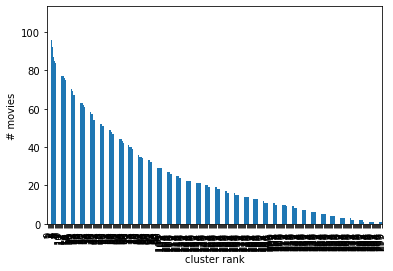

In [89]:
# plot the results
(cluster_analysis
 .toPandas()
 .sort_values('n_movies', ascending=False)
 .reset_index()
 .n_movies.plot(y='n_movies', kind='bar')
);
plt.xlabel('cluster rank')
plt.ylabel('# movies');